# Pactice notebook

Index

[CaMgO dataset](#camgo)


In [6]:
import os
import copy
import json
import itertools
import shutil as sh
from pathlib import Path
import numpy as np
import pandas as pd
import time
import ase
from datetime import datetime
import pickle
#import shap

from CRYSTALpytools.crystal_io import Crystal_output, Crystal_input, Crystal_density, Crystal_gui
from CRYSTALpytools.convert import cry_gui2pmg, cry_out2pmg
from CRYSTALpytools.utils import view_pmg

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.io.cif import CifWriter
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer, PointGroupAnalyzer

from ase.visualize import view
from ase.build import bulk

#dscribe descriptors
from dscribe.descriptors import CoulombMatrix
from dscribe.descriptors import SOAP
from dscribe.descriptors import MBTR

#matminer descriptors
#from matminer.featurizers import structure as sf

#ML algorithms
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score, max_error
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)

# <a id='camgo'>CaMgO dataset</a>

### Structures

- structures is a list of all the structures as pymatgen objects

In [7]:
new_atom = 'Mg'

#cry_output = Crystal_output('data/classification/ml/cao_CONFCNT.out')
cry_output = Crystal_output().read_cry_output('data/crystal/cao_confcount.out')

cry_output.get_config_analysis()

#original_structure = cry_gui2pmg('data/classification/ml/cao_CONFCNT.gui')
original_structure_gui =  Crystal_gui().read_cry_gui('data/crystal/cao_confcount.gui')
original_structure = cry_gui2pmg(original_structure_gui)

structures_mco = []
ca_atoms = []
mg_atoms = []
for j,substitutions in enumerate(cry_output.atom_type1):
    new_structure = original_structure.copy()
    for i in substitutions:
        new_structure.replace(i-1,new_atom)
    structures_mco.append(new_structure)
    ca_atoms.append((np.array(cry_output.atom_type1[j])-1).tolist())
    mg_atoms.append((np.array(cry_output.atom_type2[j])-1).tolist())

structures = copy.deepcopy(structures_mco)

In [5]:
#original_structure.atomic_numbers

### Single point energies & band gap

- energies_sp is a list of single point energies (non optimised geometry)
- gap_sp is a list of band gap values for the non optimised geometry

In [8]:
energies_sp = []
gap_sp = []
#structuress = []
for i in range(len(structures)):
    crystal_output = Crystal_output().read_cry_output('./data/crystal/sp/CaMgO_sp_%s.out'%str(i))
    if crystal_output.get_final_energy() != None:
        energies_sp.append(crystal_output.get_final_energy())
        gap_sp.append(crystal_output.get_band_gap())
        #structuress.append(i)

## Descriptors

In [9]:
#descriptors: setting up
atomic_numbers = [12, 8, 20]
rcut = 6.0
nmax = 8
lmax = 6

# Setting up the CM descriptor
cm = CoulombMatrix(
    n_atoms_max=54,
)

#setting up the SOAP descriptor
soap = SOAP(
    species = ["Ca", "Mg", "O"],
    periodic= True,
    r_cut=rcut,
    n_max=nmax,
    l_max=lmax
)

#setting up the MBTR descriptor
mbtr = MBTR(
    species=["Ca", "O", "Mg"],
    k1={
        "geometry": {"function": "atomic_number"},
        "grid": {"min": 0, "max": 8, "n": 200, "sigma": 0.1},
    },
    k2={
        "geometry": {"function": "inverse_distance"},
        "grid": {"min": 0, "max": 1, "n": 100, "sigma": 0.1},
        "weighting": {"function": "exp", "scale": 0.5, "threshold": 1e-3},
    },
    k3={
        "geometry": {"function": "cosine"},
        "grid": {"min": -1, "max": 1, "n": 100, "sigma": 0.1},
        "weighting": {"function": "exp", "scale": 0.5, "threshold": 1e-3},
    },
    periodic=True,
    normalization="l2_each",
    flatten=False,
    sparse=False
)

In [10]:
#changing it to the ASE structure:
Ase_struct = []
for i in range(len(structures)):
    x = AseAtomsAdaptor().get_atoms(structures[i])
    Ase_struct.append(x)

In [11]:
#CM descriptor with Dscribe
#if the n_atoms_max is already at its maximum it will just stop hence, for us, 56 and 54 produces the same result
cm_dscribe_list = []
cm_ds = CoulombMatrix(n_atoms_max=54,permutation="eigenspectrum")
start = datetime.now()
for i in range(len(Ase_struct)):
    dscribe_matrix = cm_ds.create([Ase_struct[i]])
    dscribe_matrix = np.real(dscribe_matrix)
    cm_dscribe_list.append(dscribe_matrix)
    now = datetime.now()
    if int(len(cm_dscribe_list))%200 == 0: 
        print("matrices read:", len(cm_dscribe_list),", time:", (now - start))
    
print('Number of matrices read: ', len(cm_dscribe_list))
print("--- %s time taken ---" % (datetime.now()- start))

matrices read: 200 , time: 0:00:00.041643
matrices read: 400 , time: 0:00:00.069618
matrices read: 600 , time: 0:00:00.090651
matrices read: 800 , time: 0:00:00.109723
matrices read: 1000 , time: 0:00:00.128656
matrices read: 1200 , time: 0:00:00.148242
matrices read: 1400 , time: 0:00:00.166846
matrices read: 1600 , time: 0:00:00.185066
matrices read: 1800 , time: 0:00:00.203244
matrices read: 2000 , time: 0:00:00.221555
matrices read: 2200 , time: 0:00:00.239778
matrices read: 2400 , time: 0:00:00.260961
matrices read: 2600 , time: 0:00:00.280139
matrices read: 2800 , time: 0:00:00.298984
matrices read: 3000 , time: 0:00:00.317880
matrices read: 3200 , time: 0:00:00.336608
matrices read: 3400 , time: 0:00:00.355632
matrices read: 3600 , time: 0:00:00.374930
matrices read: 3800 , time: 0:00:00.394258
matrices read: 4000 , time: 0:00:00.413633
Number of matrices read:  4023
--- 0:00:00.415945 time taken ---


In [12]:
Ener_sp = energies_sp
ener_sp = pd.DataFrame(Ener_sp)
ener_sp['CM_dscribe'] = cm_dscribe_list
ener_sp['CM_dscribe'].shape

(4023,)

In [15]:
#CM descriptors with matminer
cm_matminer_list=[]
cm_mm = sf.CoulombMatrix(flatten=True)
start = datetime.now()
for i in range(len(structures)):
    matminer_matrix = cm_mm.fit([structures[i]])
    #print('fit:', datetime.now() - start)
    featurized_structure = matminer_matrix.featurize(structures[i])
    #print("feature", datetime.now() - start)
    cm_matminer_list.append(featurized_structure)
    now = datetime.now()
    if int(len(cm_matminer_list))%200 == 0: 
        print("matrices read:", len(cm_matminer_list),", time:", (now - start))
    
print('Number of matrices read: ', len(cm_matminer_list))
print("--- %s time taken ---" % ((datetime.now() - start)))

Casting complex values to real discards the imaginary part


matrices read: 200 , time: 0:00:19.391864
matrices read: 400 , time: 0:00:37.728154
matrices read: 600 , time: 0:00:56.150882
matrices read: 800 , time: 0:01:14.550612
matrices read: 1000 , time: 0:01:32.871132
matrices read: 1200 , time: 0:01:51.353465
matrices read: 1400 , time: 0:02:09.783448
matrices read: 1600 , time: 0:02:28.360865
matrices read: 1800 , time: 0:02:46.862770
matrices read: 2000 , time: 0:03:05.383845
matrices read: 2200 , time: 0:03:23.906265
matrices read: 2400 , time: 0:03:42.061766
matrices read: 2600 , time: 0:04:00.205301
matrices read: 2800 , time: 0:04:18.375997
matrices read: 3000 , time: 0:04:36.491598
matrices read: 3200 , time: 0:04:54.579354
matrices read: 3400 , time: 0:05:13.274418
matrices read: 3600 , time: 0:05:31.771687
matrices read: 3800 , time: 0:05:50.667380
matrices read: 4000 , time: 0:06:09.182994
Number of matrices read:  4023
--- 0:06:11.337013 time taken ---


In [10]:
ener_sp['CM_Matminer'] = cm_matminer_list

In [15]:
#SOAP Descriptor
soap_dscribe_list = []
start = datetime.now()
for i in range(len(Ase_struct)):
    soap_matrix = soap.create([Ase_struct[i]])
    soap_matrix = np.real(soap_matrix)
    soap_dscribe_list.append(soap_matrix)
    now = datetime.now()
    if int(len(soap_dscribe_list)) == 20:
        print("matrices read:", len(soap_dscribe_list),", time:", (now - start))
    if int(len(soap_dscribe_list))%200 == 0: 
        print("matrices read:", len(soap_dscribe_list),", time:", (now - start))
    
print('Number of matrices read: ', len(soap_dscribe_list))
print("--- %s time taken ---" % ((datetime.now() - start)))

print(soap_dscribe_list[0].shape)


matrices read: 20 , time: 0:00:00.199294
matrices read: 200 , time: 0:00:01.680292
matrices read: 400 , time: 0:00:03.314117
matrices read: 600 , time: 0:00:04.956068
matrices read: 800 , time: 0:00:06.667197
matrices read: 1000 , time: 0:00:08.307770
matrices read: 1200 , time: 0:00:09.945258
matrices read: 1400 , time: 0:00:11.784379
matrices read: 1600 , time: 0:00:13.505250
matrices read: 1800 , time: 0:00:15.175660
matrices read: 2000 , time: 0:00:16.861443
matrices read: 2200 , time: 0:00:18.536724
matrices read: 2400 , time: 0:00:20.237149
matrices read: 2600 , time: 0:00:21.953565
matrices read: 2800 , time: 0:00:23.643429
matrices read: 3000 , time: 0:00:25.321134
matrices read: 3200 , time: 0:00:26.977106
matrices read: 3400 , time: 0:00:28.656840
matrices read: 3600 , time: 0:00:30.359644
matrices read: 3800 , time: 0:00:32.025287
matrices read: 4000 , time: 0:00:33.678255
Number of matrices read:  4023
--- 0:00:33.871527 time taken ---
(54, 2100)


In [16]:
ener_sp['SOAP'] = soap_dscribe_list
soap_dscribe_list[0].shape

(54, 2100)

In [9]:
print(soap_dscribe_list[0].shape)

(54, 2100)


In [10]:
#MBTR descriptor
mbtr_dscribe_list = []
start = datetime.now()
for i in range(len(Ase_struct)):
    mbtr_matrix = mbtr.create([Ase_struct[i]])
    mbtr_matrix = np.real(mbtr_matrix)
    mbtr_dscribe_list.append(mbtr_matrix)
    now = datetime.now()
    if int(len(mbtr_dscribe_list))%200 == 0: 
        print("matrices read:", len(mbtr_dscribe_list),", time:", (now - start))
print('Number of matrices read: ', len(mbtr_dscribe_list))
print("--- %s time taken ---" % ((datetime.now() - start)))

KeyboardInterrupt: 

In [179]:
#ener_sp['MBTR'] = mbtr_dscribe_list

In [11]:
#MBTR descriptor
#running 20 only for now, because it takes too long
mbtr_dscribe_list = []
mbtr_MM = []
start = datetime.now()
for i in range(20):
    mbtr_matrix = mbtr.create([Ase_struct[i]])
    mbtr_MM.append(mbtr_matrix)
    mbtr_matrix = np.real(mbtr_matrix)
    mbtr_dscribe_list.append(mbtr_matrix)
    now = datetime.now()
    if int(len(mbtr_dscribe_list))%200 == 0: 
        print("matrices read:", len(mbtr_dscribe_list),", time:", (now - start))
print('Number of matrices read: ', len(mbtr_dscribe_list))
print("--- %s time taken ---" % ((datetime.now() - start)))

Number of matrices read:  20
--- 0:00:23.533141 time taken ---


In [20]:
n_elements = len(mbtr.species)
imap = mbtr.index_to_atomic_number
x = np.linspace(0, 0.5, 200)
smap = {index: ase.data.chemical_symbols[number] for index, number in imap.items()}

In [21]:
output = mbtr_MM[0]
print(output['k1'].shape)
# The locations of specific element combinations can be retrieved like this.
mgo_loc = mbtr.get_location(("Mg", "O"))
o_loc = mbtr.get_location(("O"))
x = np.linspace(0, 1, 700)

(3, 200)


In [117]:
#print(output['k1'])

<Figure size 600x200 with 0 Axes>

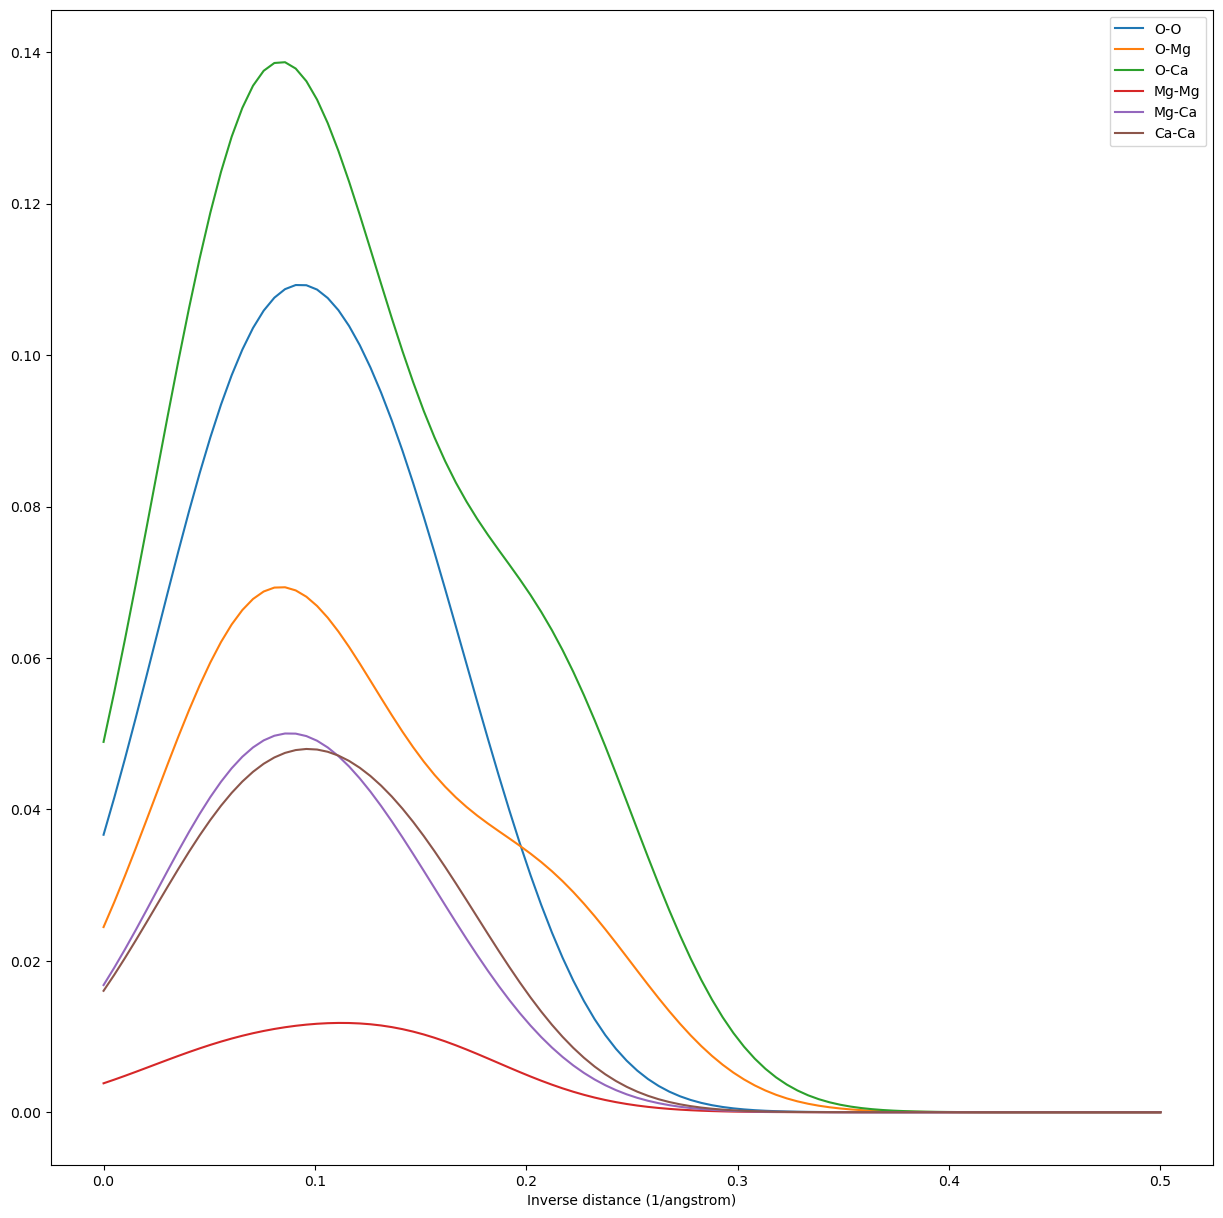

In [22]:
#this is taken from the website 
import ase.data
from ase.build import bulk
import matplotlib.pyplot as mpl

# The MBTR-object is configured with flatten=False so that we can easily
# visualize the different terms.
# Create the mapping between an index in the output and the corresponding
# chemical symbol
n_elements = len(mbtr.species)
imap = mbtr.index_to_atomic_number
x = np.linspace(0, 0.5, 100)
smap = {index: ase.data.chemical_symbols[number] for index, number in imap.items()}
#the chemical symbols

# Plot k=2
fig = plt.figure(figsize=(6, 2))
fig, ax = plt.subplots()
for i in range(n_elements):
    for j in range(n_elements):
        if j >= i:
            mpl.plot(x, mbtr_MM[0]["k2"][i, j, :], label="{}-{}".format(smap[i], smap[j]))
ax.set_xlabel("Inverse distance (1/angstrom)")
ax.legend()

## ML MODELS

In [18]:
#need to split the data frame into traning, validation and testing data
total = len(ener_sp)
e_test = ener_sp[:total//10+1]
e_val = ener_sp[total//10+1:total//10*2+1] #10% of data for validation

#defining the percentage of traning set that is used for training
split = 50


if split == int(20):
    e_train = ener_sp.iloc[total//10*2+1:total//10*4+1] #30% of data for training
elif split == int(50):
    e_train = ener_sp.iloc[total//10*2+1:total//10*7+1] #50% of data for training
elif split == int(80):
    e_train = ener_sp.iloc[total//10*2+1:total] #80% of data for training
else:
    print('Error: please choose a valid train/test split.')

In [19]:
# Print number of training data points
print('Number of training data points = ', len(e_train))
Xtrain = e_train['CM_dscribe'].to_numpy()
Xtrain = np.stack(Xtrain)
Xval   = e_val['CM_dscribe'].to_numpy()
Xval   = np.stack(Xval)
Xtest  = e_test['CM_dscribe'].to_numpy()
Xtest  = np.stack(Xtest)


ytrain = e_train[0].to_numpy()
yval   = e_val[0].to_numpy()
ytest  = e_test[0].to_numpy()


Number of training data points =  2010


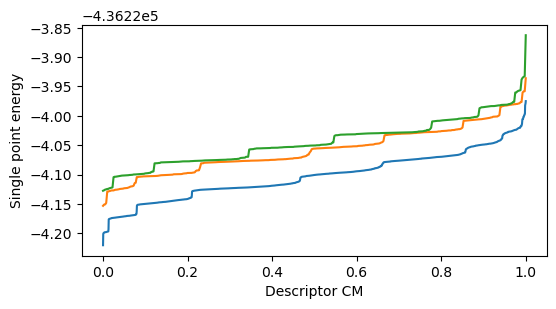

In [10]:
#Visualization of the distribution of values among the different sets: training, validation and test.

plt.figure(figsize = (6, 3))
plt.plot(np.linspace(0,1,len(ytrain)),sorted(ytrain))
plt.plot(np.linspace(0,1,len(yval)),sorted(yval))
plt.plot(np.linspace(0,1,len(ytest)),sorted(ytest))
plt.xlabel('Descriptor CM')
plt.ylabel('Single point energy')
plt.show()
plt.close()

In [20]:
#copied from keith butler's
#Generic function to score the performing of the model and plot the predictions
def score_model(realval,preds,print_results=False,graph=False,print_ingraph=False,savegraph=False):
    mae = mean_absolute_error(realval,preds)*1000
    maxerr= max(abs(preds.reshape(len(preds),)-realval))*1000
    r2=r2_score(realval,preds)
    if print_results==True:
        print('Mean absolute error {} meV'.format(mae))
        print('Maximum error {} meV'.format(maxerr))
        print('R2 = {}'.format(r2))
    if graph==True:
        plt.figure(dpi=600)
    else:
        plt.figure()
        plt.plot(realval.reshape(len(preds),),preds,'o')
        vmin=min(min(realval),min(preds));vmax=max(max(realval),max(preds))
        eje=np.linspace(vmin,vmax,10)
        plt.plot(eje,eje)
        plt.ylabel("Predicted values")
        plt.xlabel("Calculated values")
        plt.title("Bandgaps (eV)")
        ax=plt.gca()
        ax.set_xlim([vmin-0.01,vmax+0.01]);ax.set_ylim([vmin-0.01,vmax+0.01])
        ax.set_aspect('equal', adjustable='box')
        if print_ingraph==True:
            xtags=vmin+0.07*(vmax-vmin)
            yperc=np.array([0.9,0.85,0.8,0.75,0.7,0.65,0.6])
            ytags=vmin+yperc*(vmax-vmin)
            plt.text(xtags,ytags[0], "MAE = "+'%.2f' % (mae) +" meV")
            plt.text(xtags,ytags[1], r'$\epsilon$$_{max}$ = '+'%.2f' % (maxerr) +" meV")
            plt.text(xtags,ytags[2], r'R$^2$ = '+'%.3f' % r2)
        if savegraph==True:
            plt.savefig('LR_'+CM_dscribe+feature+".png")
        plt.show()
        plt.close()
    return mae,maxerr,r2

Mean absolute error 37.032078234473055 meV
Maximum error 137.37523136660457 meV
R2 = -0.29729583219211686


NameError: name 'CM_dscribe' is not defined

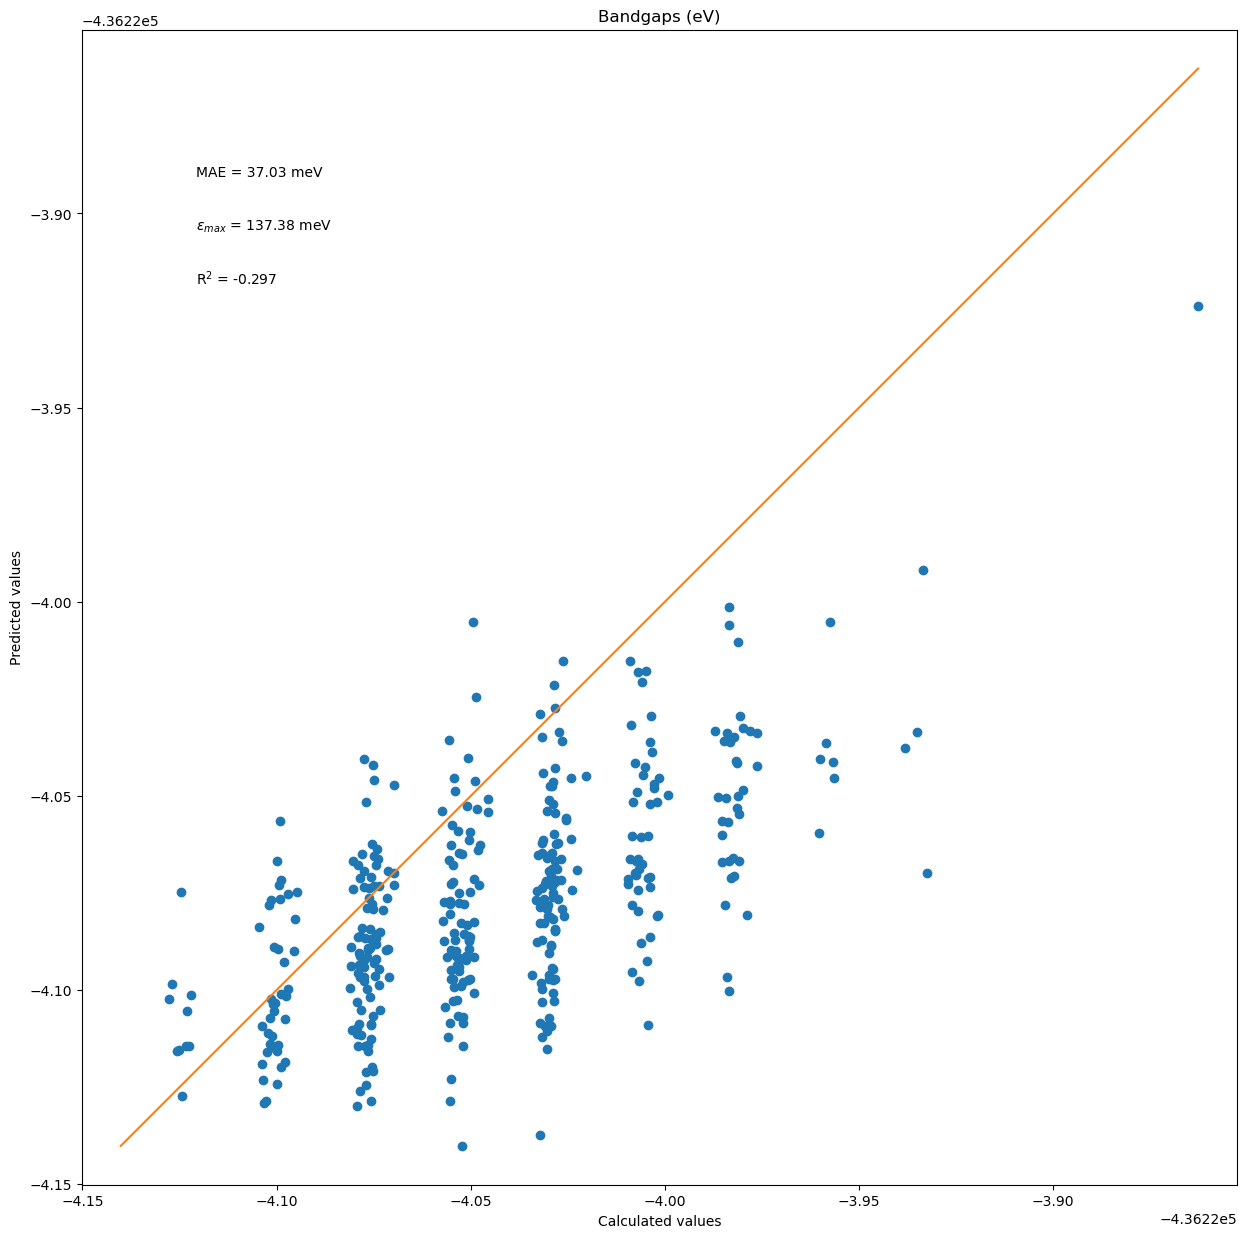

In [21]:
# Test linear regressor.

model = LinearRegression()

#print(Xtrain)
#print(ytrain)


model.fit(Xtrain, ytrain)
ypred_LR = model.predict(Xtest)
mae_LR,maxerr_LR,r2_LR=score_model(ytest,ypred_LR,print_results=True,graph=False,print_ingraph=True,savegraph=True)

#plt.figure(figsize = (6, 4))
#plt.scatter(ytest, ypred_LR)


In [246]:
#obj = pd.read_pickle(r'input_data_mbtr.pkl')

In [30]:
#convert y values to categorical values
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(ytrain)


#support vector classification 


model = svm.SVC()
model.fit(Xtrain, y_transformed)
ypred = model.predict(Xtest)
#mae_SVC,maxerr_SVC,r2_SVC=score_model(ytest,ypred,print_results=True,graph=True,print_ingraph=True,savegraph=True)

plt.figure(figsize = (6, 4))
#plt.scatter(ytest, ypred)
#unable to get it to work, when using LabelEncoder(), the ypred values became all 572, without it error: ValueError: Unknown label type: 'continuous'.

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

In [31]:
#directly obtained from Keith Butler's paper, will learn what the parameters mean later
#defining the parameteres for GBDT
params = {'n_estimators': 1000,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'squared_error'}
model = GradientBoostingRegressor(**params)

Mean absolute error 36.6575283282344 meV
Maximum error 146.89117099624127 meV
R2 = -0.2444003679151716


<Figure size 9000x9000 with 0 Axes>

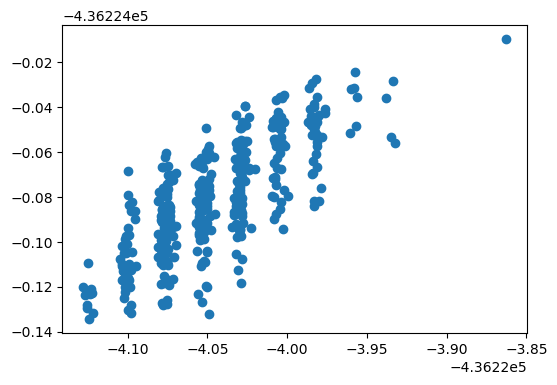

In [33]:
model.fit(Xtrain, ytrain)
ypred_GBDT = model.predict(Xtest)
mae_GBDT,maxerr_GBDT,r2_GBDT=score_model(ytest,ypred_GBDT,print_results=True,graph=True,print_ingraph=True,savegraph=True)

plt.figure(figsize = (6, 4))
plt.scatter(ytest, ypred_GBDT)